# Tasseled cap index 

**Notebook currently compatible with the `DEA Sandbox` environment only**

### General advice (delete this cell before submitting for review)

- When choosing a location for your analysis, **select an area that has data on both the `NCI` and `DEA Sandbox`** to allow your code to be run on both environments. 
For example, you can check this for Landsat using the [DEA Explorer](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3/1990) (use the drop-down menu to view all products). 
As of September 2019, the `DEA Sandbox` has a single year of continental Landsat data for 2015-16, and the full 1987-onward time-series for three locations (Perth WA, Brisbane QLD, and western NSW).
- When writing in Markdown cells, start each sentence is on a **new line**.
This makes it easy to see changes through git commits.
- Use Australian English in markdown cells and code comments.
- Use the [PEP8 standard](https://www.python.org/dev/peps/pep-0008/) for code. To make sure all code in the notebook is consistent, you can use the `jupyterlab_code_formatter` tool: select each code cell, then click `Edit` and then one of the `Apply X Formatter` options (`YAPF` or `Black` are recommended). This will reformat the code in the cell to a consistent style.
- In the final notebook cell, include a set of relevant tags which are used to build the DEA User Guide's [Tag Index](https://docs.dea.ga.gov.au/genindex.html). 
Use all lower-case, seperate words with spaces, and where possible re-use existing tags.
Ensure the tags cell below is in `Raw` format, rather than `Markdown` or `Code`.


### Background
Data from the [Landsat](https://landsat.usgs.gov/about-landsat) 5,7 and 8 satellite missions are accessible through [Digital Earth Australia](http://www.ga.gov.au/about/projects/geographic/digital-earth-australia) (DEA). 

The *Tasseled Cap Index (TCI)* is a method of reducing 6 bands of satellite data (BLUE, GREEN, RED, NIR, SWIR1, SWIR2) to 3 bands (Brightness, Greenness, Wetness) using a Principal Components Analysis and Procrustes' Rotation [(Roberts et al 2018)](https://doi.org/10.1109/igarss.2018.8518312). This notebook uses the published coefficients of [Crist 1985](https://doi.org/10.1016/0034-4257(85)90102-6) as applied to Digital Earth Australia's Landsat satellite data.This notebook produces the wetness index.

### Description
This notebook demonstrates using the `dea_bandindices` function to calculate a tasseled cap wetness transform on Landsat data. 

### Technical details
* **Products used:** 
[`ga_ls5t_ard_3`](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3/1990), 
[`ga_ls7e_ard_3`](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3/2000), 
[`ga_ls8c_ard_3`](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3/2016),

* **Analyses used:** TCW water index

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff

#----FIXME for SANDBOX  -- fix bandindices calculations
sys.path.append('../Scripts')
sys.path.append('../10_Scripts')
from dea_datahandling import load_ard
import dea_plotting, dea_bandindices, dea_tasseledcaptools, BandIndices

%load_ext autoreload

%autoreload 2

In [2]:
### Connect to the datacube
# Temporary solution to account for Collection 3 data being in a different
# database on the NCI
try:
    dc_landsat = datacube.Datacube(app='Calculating_Tasseled_cap', env='c3-samples')
except:
    dc_landsat = datacube.Datacube(app='Calculating_Tasseled_cap')

### Analysis parameters

An *optional* section to inform the user of any parameters they'll need to configure to run the notebook:
* `param_name_1`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.
* `param_name_2`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.


In [3]:
param_name_1 = "example_value"
param_name_2 = "example_value"

## Use `load_ard` function to get cloud-free Landsat satellite data

In [4]:
# Create a reusable query
query = {
    'x': (153.38, 153.47),
    'y': (-28.83, -28.92),
    'time': ('2017-06', '2018-06'),
    'measurements': ['nbart_blue', 'nbart_green','nbart_red', 'nbart_nir','nbart_swir_1','nbart_swir_2'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Load available data from all three Landsat satellites and filter to retain only times with at least 99% good data
ds = load_ard(dc=dc_landsat, 
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'], 
              min_gooddata=0.99,
              **query)

Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Filtering to 0 out of 25 observations
Loading ga_ls8c_ard_3 data
    Filtering to 6 out of 25 observations
    Applying pixel quality mask
Combining and sorting data
    Masking out invalid values
    Returning 6 observations 


### Have a look at one scene to see what it looks like

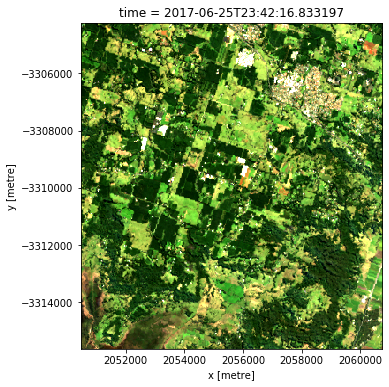

In [5]:
dea_plotting.rgb(ds, index=0)

### Calculate the Tasseled Cap Wetness index on the Landsat data
First calculate the TCW using the `dea_bandindices` function

In [6]:
# Calculate the TCW specifying that we're using collection 3 data. 
# Note that the calculate_indices function normalises as default behaviour
#tcw = dea_bandindices.calculate_indices(ds, collection='ga_ls_3',index='TCW',drop=True)

In [7]:
tci =dea_bandindices.calculate_indices(ds,collection='ga_ls_3',index=['NDWI','NDVI','TCB'],drop=True,deep_copy=False)

dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


In [8]:
tci

<xarray.Dataset>
Dimensions:  (time: 6, x: 342, y: 380)
Coordinates:
  * time     (time) datetime64[ns] 2017-06-25T23:42:16.833197 ... 2018-06-28T23:41:33.464057
  * x        (x) float64 2.05e+06 2.051e+06 2.051e+06 ... 2.061e+06 2.061e+06
  * y        (y) float64 -3.304e+06 -3.304e+06 ... -3.316e+06 -3.316e+06
Data variables:
    NDWI     (time, y, x) float32 -0.7192288 -0.75278765 ... 0.5991903
    NDVI     (time, y, x) float32 0.78542095 0.806357 ... 0.36530617 -0.46195653
    TCB      (time, y, x) float32 0.28429902 0.29116246 ... 0.043573603
Attributes:
    crs:      EPSG:3577

## Heading 2
Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.

In [9]:
# Use code comments for low-level documentation of code
c = 3

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2019

**Compatible `datacube` version:** 

In [10]:
print(datacube.__version__)

1.7+43.gc873f3ea.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)